# Inversion with a configuration file

In this notebook we show how to use a configuration file to run Hazel in different situations for inverting Stokes profiles.

## On-disk inversions
Let's first a set of observations obtained from the GREGOR telescope as example. The observations consisted of a scan of an active region in which filaments are seen when observed in the core of the He I 10830 A line. 

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as pl
import hazel
import h5py
import scipy.io as io
print(hazel.__version__)
label = ['I', 'Q', 'U', 'V']

/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


2018.06.07


First read the observations and do some plots. The wavelength axis in the save file is given in displacement with respect to some reference wavelength, in this case 10830.0911 A.

dict_keys(['heperf', 'lambda'])
210


/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


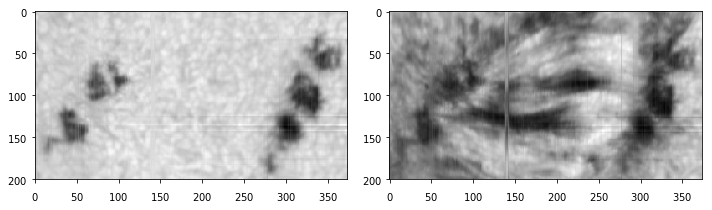

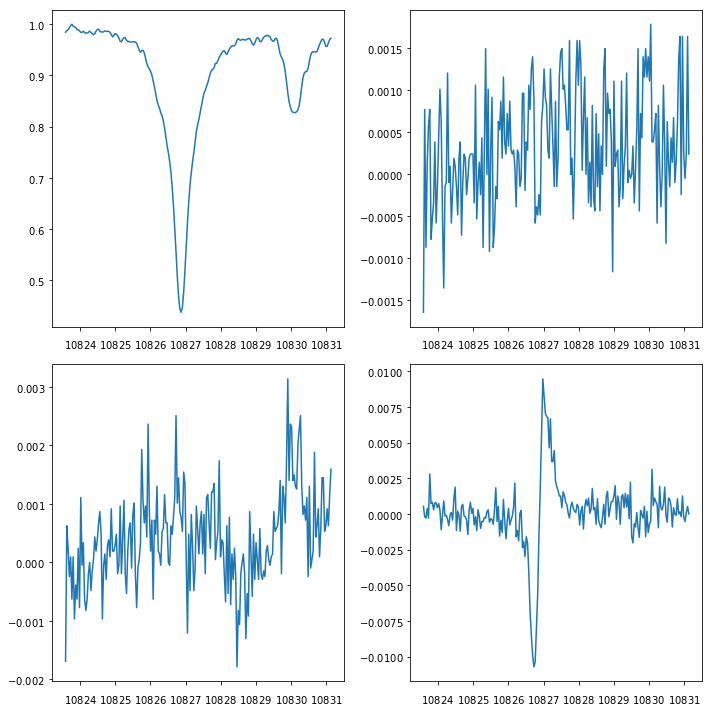

In [2]:
tmp = io.readsav('/scratch/Dropbox/test/test_hazel2/orozco/gregor_spot.sav')
print(tmp.keys())
f, ax = pl.subplots(nrows=1, ncols=2, figsize=(10,6))
ax[0].imshow(tmp['heperf'][:,0,:,0])
ax[1].imshow(tmp['heperf'][:,0,:,181])

f, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
stokes = np.zeros((4,210))
stokes[0,:] = tmp['heperf'][160,0,130,0:-40] / np.max(tmp['heperf'][160,0,130,:])
stokes[1,:] = tmp['heperf'][160,1,130,0:-40] / np.max(tmp['heperf'][160,0,130,:])
stokes[2,:] = tmp['heperf'][160,2,130,0:-40] / np.max(tmp['heperf'][160,0,130,:])
stokes[3,:] = tmp['heperf'][160,3,130,0:-40] / np.max(tmp['heperf'][160,0,130,:])
ax[0,0].plot(tmp['lambda'][0:-40] + 10830.0911, stokes[0,:])
ax[0,1].plot(tmp['lambda'][0:-40] + 10830.0911, stokes[1,:])
ax[1,0].plot(tmp['lambda'][0:-40] + 10830.0911, stokes[2,:])
ax[1,1].plot(tmp['lambda'][0:-40] + 10830.0911, stokes[3,:])

wvl = tmp['lambda'][0:-40]
stokes = stokes[:,:]
n_lambda = len(wvl)
print(n_lambda)

Now we save 1D files for the inversion. First the wavelength axis:

In [3]:
np.savetxt('10830_spot.wavelength', wvl+10830.0911, header='lambda')

Then, let's assume that we weight all wavelengths equally:

In [4]:
f = open('10830_spot.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(n_lambda):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()
stokes.shape

(4, 210)

Finally, let's compute a very rough estimation of the noise standard deviation and save the Stokes parameters in a file, that we also print so that you can check the required format.

In [5]:
noise = np.std(stokes[1,0:20])
f = open('10830_spot_stokes.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'0.0 0.0 90.0\n')
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'1.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes, noise*np.ones((4,n_lambda))])
np.savetxt(f, tmp.T)
f.close()

%cat 10830_spot_stokes.1d

# LOS theta_LOS, phi_LOS, gamma_LOS
0.0 0.0 90.0

# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)
1.0 0.0 0.0 0.0

# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV
9.844778180122375488e-01 -1.641324721276760101e-03 -1.689598895609378815e-03 5.310168489813804626e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04
9.873363971710205078e-01 7.723881280981004238e-04 6.275653140619397163e-04 -1.930970320245251060e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04
9.892690181732177734e-01 -8.689365931786596775e-04 2.413712936686351895e-04 -2.896455407608300447e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04
9.933860301971435547e-01 1.448227703804150224e-04 -2.413712936686351895e-04 3.861940640490502119e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04 7.616745996946300539e-04
9.975462555885314

So we are now ready for the inversion. Let's print first the configuration file and then do a simple inversion for a 1D input file. You can see that we are including two atmospheres, a photosphere to explain the Si I line and a chromosphere to explain the He I multiplet. We also give some rough intervals for the parameters.

In [6]:
%cat conf_spot.ini

# Hazel configuration File

[Working mode]
Output file = output.h5
Number of cycles = 2

# Topology
# Always photosphere and then chromosphere
# Photospheres are only allowed to be added with a filling factor
# Atmospheres share a filling factor if they are in parenthesis
# Atmospheres are one after the other with the -> operator
# Atmosphere 1 = ph2 -> ch1 -> ch2

[Spectral regions]
    [[Region 1]]
    Name = spec1
    Topology = ph1 -> ch1
    Stokes weights = 1.0, 1.0, 1.0, 1.0
    LOS = 0.0, 0.0, 90.0
    Boundary condition = 1.0, 0.0, 0.0, 0.0       # I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)
    Wavelength file = '10830_spot.wavelength'
    Wavelength weight file = '10830_spot.weights'
    Observations file = '10830_spot_stokes.1d'    
    Weights Stokes I = 1.0, 0.1, 0.0, 0.0
    Weights Stokes Q = 0.0, 10.0, 0.0, 0.0
    Weights Stokes U = 0.0, 10.0, 0.0, 0.0
    Weights Stokes V = 0.0, 1.0, 0.0, 0.0
    Mask file = None

[Atmospheres]

    [[Chromosphere 1]]
    Name = c

In [7]:
mod = hazel.Model('conf_spot.ini', working_mode='inversion', verbose=3)
mod.read_observation()
mod.open_output()
mod.invert()
mod.write_output()
mod.close_output()

2018-09-13 12:28:10,649 - Adding spectral region spec1
2018-09-13 12:28:10,650 -   - Reading wavelength axis from 10830_spot.wavelength
2018-09-13 12:28:10,653 -   - Reading wavelength weights from 10830_spot.weights
2018-09-13 12:28:10,658 -   - Using observations from 10830_spot_stokes.1d
2018-09-13 12:28:10,659 -   - No mask for pixels
2018-09-13 12:28:10,660 -   - No instrumental profile
2018-09-13 12:28:10,660 -   - Using LOS ['0.0', '0.0', '90.0']
2018-09-13 12:28:10,661 -   - Using boundary condition ['1.0', '0.0', '0.0', '0.0']
2018-09-13 12:28:10,663 - Using 2 cycles
2018-09-13 12:28:10,663 - Not using randomizations
2018-09-13 12:28:10,664 - Adding atmospheres
2018-09-13 12:28:10,665 -   - New available chromosphere : ch1
2018-09-13 12:28:10,666 -     * Adding line : 10830
2018-09-13 12:28:10,667 -     * Magnetic field reference frame : vertical
2018-09-13 12:28:10,668 -     * Reading 1D model chromospheres/model_spicules.1d as reference
2018-09-13 12:28:10,670 -   - New avai

     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.287    -1.554    11.227     1.000     0.049


2018-09-13 12:28:14,019 -   - Backtracking:  0 - lambda: 1.93990 - chi2: 491.18344
2018-09-13 12:28:14,132 -   - Backtracking:  1 - lambda: 0.61345 - chi2: 357.09607
2018-09-13 12:28:14,254 -   - Backtracking:  2 - lambda: 0.19399 - chi2: 271.44862
2018-09-13 12:28:14,373 -   - Backtracking:  3 - lambda: 0.06135 - chi2: 220.94389
2018-09-13 12:28:14,536 -   - Backtracking:  4 - lambda: 0.01940 - chi2: 192.79261
2018-09-13 12:28:14,700 -   - Backtracking:  5 - lambda: 0.00613 - chi2: 185.54531
2018-09-13 12:28:14,859 -   - Backtracking:  6 - lambda: 0.00194 - chi2: 187.64828
2018-09-13 12:28:14,861 -   * Optimal lambda: 0.00446925549141787
2018-09-13 12:28:15,015 -  * RF to T - ph1 - nodes=3
2018-09-13 12:28:15,131 -  * RF to vmic - ph1 - nodes=1
2018-09-13 12:28:15,172 -  * RF to v - ph1 - nodes=1
2018-09-13 12:28:15,211 -  * RF to tau - ch1 - nodes=1
2018-09-13 12:28:15,253 -  * RF to v - ch1 - nodes=1
2018-09-13 12:28:15,410 -  * RF to deltav - ch1 - nodes=1
2018-09-13 12:28:15,575 -

     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.259    -4.324    11.951     1.000     0.001


2018-09-13 12:28:15,875 -   - Backtracking:  0 - lambda: 0.44693 - chi2: 243.34706
2018-09-13 12:28:15,988 -   - Backtracking:  1 - lambda: 0.14133 - chi2: 209.00481
2018-09-13 12:28:16,101 -   - Backtracking:  2 - lambda: 0.04469 - chi2: 182.62475
2018-09-13 12:28:16,239 -   - Backtracking:  3 - lambda: 0.01413 - chi2: 160.84318
2018-09-13 12:28:16,352 -   - Backtracking:  4 - lambda: 0.00447 - chi2: 146.04196
2018-09-13 12:28:16,491 -   - Backtracking:  5 - lambda: 0.00141 - chi2: 138.80650
2018-09-13 12:28:16,616 -   - Backtracking:  6 - lambda: 0.00045 - chi2: 136.20400
2018-09-13 12:28:16,749 -   * Backtracking:  0 - lambda: 0.44693 - chi2: 243.34706
2018-09-13 12:28:16,941 -   * Backtracking:  1 - lambda: 1.41330 - chi2: 163.27093
2018-09-13 12:28:17,103 -   * Backtracking:  2 - lambda: 4.46926 - chi2: 174.62839
2018-09-13 12:28:17,105 -   * Optimal lambda: 0.0004469255491417868
2018-09-13 12:28:17,229 -  * RF to T - ph1 - nodes=3
2018-09-13 12:28:17,358 -  * RF to vmic - ph1 - n

     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.295    -4.589     6.000     1.000     0.100


2018-09-13 12:28:17,887 -   - Backtracking:  0 - lambda: 0.04469 - chi2: 94.42545
2018-09-13 12:28:18,004 -   - Backtracking:  1 - lambda: 0.01413 - chi2: 92.81418
2018-09-13 12:28:18,157 -   - Backtracking:  2 - lambda: 0.00447 - chi2: 91.70352
2018-09-13 12:28:18,271 -   - Backtracking:  3 - lambda: 0.00141 - chi2: 91.37402
2018-09-13 12:28:18,389 -   - Backtracking:  4 - lambda: 0.00045 - chi2: 91.32445
2018-09-13 12:28:18,501 -   * Backtracking:  0 - lambda: 0.04469 - chi2: 94.42545
2018-09-13 12:28:18,615 -   * Backtracking:  1 - lambda: 0.14133 - chi2: 95.86494
2018-09-13 12:28:18,728 -   * Backtracking:  2 - lambda: 0.44693 - chi2: 98.51022
2018-09-13 12:28:18,868 -   * Backtracking:  3 - lambda: 1.41330 - chi2: 105.35585
2018-09-13 12:28:18,869 -   * Optimal lambda: 0.0004469255491417867
2018-09-13 12:28:19,006 -  * RF to T - ph1 - nodes=3
2018-09-13 12:28:19,128 -  * RF to vmic - ph1 - nodes=1
2018-09-13 12:28:19,169 -  * RF to v - ph1 - nodes=1
2018-09-13 12:28:19,211 -  * RF

     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.358    -5.195     6.000     1.000     0.100


2018-09-13 12:28:19,688 -   - Backtracking:  0 - lambda: 0.04469 - chi2: 90.92123
2018-09-13 12:28:19,802 -   - Backtracking:  1 - lambda: 0.01413 - chi2: 90.91579
2018-09-13 12:28:19,916 -   - Backtracking:  2 - lambda: 0.00447 - chi2: 90.91395
2018-09-13 12:28:20,031 -   - Backtracking:  3 - lambda: 0.00141 - chi2: 90.91316
2018-09-13 12:28:20,144 -   - Backtracking:  4 - lambda: 0.00045 - chi2: 90.91326
2018-09-13 12:28:20,146 -   * Optimal lambda: 0.0009017445454787562
2018-09-13 12:28:20,265 -  * RF to T - ph1 - nodes=3
2018-09-13 12:28:20,385 -  * RF to vmic - ph1 - nodes=1
2018-09-13 12:28:20,426 -  * RF to v - ph1 - nodes=1
2018-09-13 12:28:20,469 -  * RF to tau - ch1 - nodes=1
2018-09-13 12:28:20,510 -  * RF to v - ch1 - nodes=1
2018-09-13 12:28:20,622 -  * RF to deltav - ch1 - nodes=1
2018-09-13 12:28:20,736 -  * RF to a - ch1 - nodes=1
2018-09-13 12:28:20,780 - It: 4 - chi2: 90.91308814387169 - lambda: 0.0009017445454787562 - rel: -0.0045145693402952715


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.354    -5.324     6.000     1.000     0.100


2018-09-13 12:28:20,950 -   - Backtracking:  0 - lambda: 0.09017 - chi2: 90.89498
2018-09-13 12:28:21,069 -   - Backtracking:  1 - lambda: 0.02852 - chi2: 90.89520
2018-09-13 12:28:21,182 -   - Backtracking:  2 - lambda: 0.00902 - chi2: 90.89488
2018-09-13 12:28:21,295 -   - Backtracking:  3 - lambda: 0.00285 - chi2: 90.89497
2018-09-13 12:28:21,296 -   * Optimal lambda: 0.006552604158239513
2018-09-13 12:28:21,410 -  * RF to T - ph1 - nodes=3
2018-09-13 12:28:21,531 -  * RF to vmic - ph1 - nodes=1
2018-09-13 12:28:21,571 -  * RF to v - ph1 - nodes=1
2018-09-13 12:28:21,614 -  * RF to tau - ch1 - nodes=1
2018-09-13 12:28:21,661 -  * RF to v - ch1 - nodes=1
2018-09-13 12:28:21,774 -  * RF to deltav - ch1 - nodes=1
2018-09-13 12:28:21,886 -  * RF to a - ch1 - nodes=1
2018-09-13 12:28:21,928 - It: 5 - chi2: 90.89470270323368 - lambda: 0.006552604158239513 - rel: -0.00020225140575493911


     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.354    -5.365     6.000     1.000     0.100


2018-09-13 12:28:22,046 -   - Backtracking:  0 - lambda: 0.65526 - chi2: 90.89473
2018-09-13 12:28:22,161 -   - Backtracking:  1 - lambda: 0.20721 - chi2: 90.89553
2018-09-13 12:28:22,276 -   - Backtracking:  2 - lambda: 0.06553 - chi2: 90.89539
2018-09-13 12:28:22,396 -   - Backtracking:  3 - lambda: 0.02072 - chi2: 90.89582
2018-09-13 12:28:22,513 -   - Backtracking:  4 - lambda: 0.00655 - chi2: 90.89514
2018-09-13 12:28:22,632 -   - Backtracking:  5 - lambda: 0.00207 - chi2: 90.89554
2018-09-13 12:28:22,744 -   - Backtracking:  6 - lambda: 0.00066 - chi2: 90.89568
2018-09-13 12:28:22,858 -   * Backtracking:  0 - lambda: 0.65526 - chi2: 90.89473
2018-09-13 12:28:22,970 -   * Backtracking:  1 - lambda: 2.07212 - chi2: 90.89497
2018-09-13 12:28:23,083 -   * Backtracking:  2 - lambda: 6.55260 - chi2: 90.89498
2018-09-13 12:28:23,196 -   * Backtracking:  3 - lambda: 20.72115 - chi2: 90.89475
2018-09-13 12:28:23,197 -   * Optimal lambda: 0.6552604158239512
2018-09-13 12:28:23,310 -  * RF 

     Bx        By        Bz        tau       v       deltav      beta      a
   0.000     0.000     0.000     0.354    -5.372     6.000     1.000     0.100


2018-09-13 12:28:23,874 -  * RF to T - ph1 - nodes=3
2018-09-13 12:28:23,994 -  * RF to vmic - ph1 - nodes=1
2018-09-13 12:28:24,034 -  * RF to v - ph1 - nodes=1
2018-09-13 12:28:24,075 -  * RF to tau - ch1 - nodes=1
2018-09-13 12:28:24,117 -  * RF to v - ch1 - nodes=1
2018-09-13 12:28:24,232 -  * RF to deltav - ch1 - nodes=1
2018-09-13 12:28:24,345 -  * RF to a - ch1 - nodes=1
2018-09-13 12:28:24,399 - -------------
2018-09-13 12:28:24,400 -   Cycle 1  
2018-09-13 12:28:24,401 -   Weights for region spec1 : SI=0.1 - SQ=10.0 - SU=10.0 - SV=1.0
2018-09-13 12:28:24,402 - -------------
2018-09-13 12:28:24,403 - Free parameters for ch1
2018-09-13 12:28:24,404 -   - Bx with 1 node
2018-09-13 12:28:24,405 -   - By with 1 node
2018-09-13 12:28:24,405 -   - Bz with 1 node
2018-09-13 12:28:24,406 - Free parameters for ph1
2018-09-13 12:28:24,407 -   - Bz with 1 node
2018-09-13 12:28:24,464 -  * RF to Bz - ph1 - nodes=1
2018-09-13 12:28:24,558 -  * RF to Bx - ch1 - nodes=1
2018-09-13 12:28:24,70

     Bx        By        Bz        tau       v       deltav      beta      a
   0.655     1.569   -21.470     0.354    -5.372     6.000     1.000     0.100


2018-09-13 12:28:27,255 -   - Backtracking:  0 - lambda: 6.55260 - chi2: 15.18990
2018-09-13 12:28:27,401 -   - Backtracking:  1 - lambda: 2.07212 - chi2: 15.37635
2018-09-13 12:28:27,543 -   - Backtracking:  2 - lambda: 0.65526 - chi2: 16.10217
2018-09-13 12:28:27,683 -   - Backtracking:  3 - lambda: 0.20721 - chi2: 16.40341
2018-09-13 12:28:27,822 -   - Backtracking:  4 - lambda: 0.06553 - chi2: 16.47191
2018-09-13 12:28:27,962 -   - Backtracking:  5 - lambda: 0.02072 - chi2: 16.48833
2018-09-13 12:28:28,101 -   - Backtracking:  6 - lambda: 0.00655 - chi2: 16.49287
2018-09-13 12:28:28,242 -   * Backtracking:  0 - lambda: 6.55260 - chi2: 15.18990
2018-09-13 12:28:28,382 -   * Backtracking:  1 - lambda: 20.72115 - chi2: 15.42474
2018-09-13 12:28:28,522 -   * Backtracking:  2 - lambda: 65.52604 - chi2: 15.53201
2018-09-13 12:28:28,664 -   * Backtracking:  3 - lambda: 207.21154 - chi2: 15.56067
2018-09-13 12:28:28,665 -   * Optimal lambda: 6.55260415823951
2018-09-13 12:28:28,807 -  * RF

     Bx        By        Bz        tau       v       deltav      beta      a
  10.102     1.947   -20.120     0.354    -5.372     6.000     1.000     0.100


2018-09-13 12:28:29,452 -   - Backtracking:  0 - lambda: 655.26042 - chi2: 15.18705
2018-09-13 12:28:29,596 -   - Backtracking:  1 - lambda: 207.21154 - chi2: 15.18095
2018-09-13 12:28:29,741 -   - Backtracking:  2 - lambda: 65.52604 - chi2: 15.16213
2018-09-13 12:28:29,886 -   - Backtracking:  3 - lambda: 20.72115 - chi2: 15.10811
2018-09-13 12:28:30,031 -   - Backtracking:  4 - lambda: 6.55260 - chi2: 15.00651
2018-09-13 12:28:30,178 -   - Backtracking:  5 - lambda: 2.07212 - chi2: 15.46690
2018-09-13 12:28:30,180 -   * Optimal lambda: 9.462730666716233
2018-09-13 12:28:30,348 -  * RF to Bz - ph1 - nodes=1
2018-09-13 12:28:30,417 -  * RF to Bx - ch1 - nodes=1
2018-09-13 12:28:30,558 -  * RF to By - ch1 - nodes=1
2018-09-13 12:28:30,699 -  * RF to Bz - ch1 - nodes=1
2018-09-13 12:28:30,842 - It: 2 - chi2: 15.03794957351954 - lambda: 9.462730666716233 - rel: -0.010053645397476274


     Bx        By        Bz        tau       v       deltav      beta      a
  10.771     3.301   -16.796     0.354    -5.372     6.000     1.000     0.100


2018-09-13 12:28:30,988 -   - Backtracking:  0 - lambda: 946.27307 - chi2: 15.03662
2018-09-13 12:28:31,130 -   - Backtracking:  1 - lambda: 299.23782 - chi2: 15.03375
2018-09-13 12:28:31,271 -   - Backtracking:  2 - lambda: 94.62731 - chi2: 15.02513
2018-09-13 12:28:31,411 -   - Backtracking:  3 - lambda: 29.92378 - chi2: 15.00245
2018-09-13 12:28:31,553 -   - Backtracking:  4 - lambda: 9.46273 - chi2: 15.00546
2018-09-13 12:28:31,554 -   * Optimal lambda: 19.257411108715743
2018-09-13 12:28:31,701 -  * RF to Bz - ph1 - nodes=1
2018-09-13 12:28:31,770 -  * RF to Bx - ch1 - nodes=1
2018-09-13 12:28:31,918 -  * RF to By - ch1 - nodes=1
2018-09-13 12:28:32,089 -  * RF to Bz - ch1 - nodes=1
2018-09-13 12:28:32,230 - It: 3 - chi2: 14.99054606782195 - lambda: 19.257411108715743 - rel: -0.0031572347988240387


     Bx        By        Bz        tau       v       deltav      beta      a
  10.034     3.788   -14.020     0.354    -5.372     6.000     1.000     0.100


2018-09-13 12:28:32,400 -   - Backtracking:  0 - lambda: 1925.74111 - chi2: 14.98997
2018-09-13 12:28:32,541 -   - Backtracking:  1 - lambda: 608.97281 - chi2: 14.98882
2018-09-13 12:28:32,682 -   - Backtracking:  2 - lambda: 192.57411 - chi2: 14.98526
2018-09-13 12:28:32,822 -   - Backtracking:  3 - lambda: 60.89728 - chi2: 14.97578
2018-09-13 12:28:32,970 -   - Backtracking:  4 - lambda: 19.25741 - chi2: 14.96138
2018-09-13 12:28:33,112 -   - Backtracking:  5 - lambda: 6.08973 - chi2: 15.02246
2018-09-13 12:28:33,113 -   * Optimal lambda: 27.49397037609885
2018-09-13 12:28:33,278 -  * RF to Bz - ph1 - nodes=1
2018-09-13 12:28:33,351 -  * RF to Bx - ch1 - nodes=1
2018-09-13 12:28:33,493 -  * RF to By - ch1 - nodes=1
2018-09-13 12:28:33,636 -  * RF to Bz - ch1 - nodes=1
2018-09-13 12:28:33,799 - It: 4 - chi2: 14.964975024842344 - lambda: 27.49397037609885 - rel: -0.0017072674449898839


     Bx        By        Bz        tau       v       deltav      beta      a
   9.188     4.014   -14.687     0.354    -5.372     6.000     1.000     0.100


2018-09-13 12:28:33,945 -   - Backtracking:  0 - lambda: 2749.39704 - chi2: 14.96472
2018-09-13 12:28:34,090 -   - Backtracking:  1 - lambda: 869.43568 - chi2: 14.96419
2018-09-13 12:28:34,234 -   - Backtracking:  2 - lambda: 274.93970 - chi2: 14.96264
2018-09-13 12:28:34,373 -   - Backtracking:  3 - lambda: 86.94357 - chi2: 14.95845
2018-09-13 12:28:34,513 -   - Backtracking:  4 - lambda: 27.49397 - chi2: 14.95275
2018-09-13 12:28:34,654 -   - Backtracking:  5 - lambda: 8.69436 - chi2: 15.04848
2018-09-13 12:28:34,655 -   * Optimal lambda: 45.82915107133699
2018-09-13 12:28:34,803 -  * RF to Bz - ph1 - nodes=1
2018-09-13 12:28:34,872 -  * RF to Bx - ch1 - nodes=1
2018-09-13 12:28:35,016 -  * RF to By - ch1 - nodes=1
2018-09-13 12:28:35,163 -  * RF to Bz - ch1 - nodes=1
2018-09-13 12:28:35,306 - It: 5 - chi2: 14.954592695371382 - lambda: 45.82915107133699 - rel: -0.0006940160077211329


     Bx        By        Bz        tau       v       deltav      beta      a
   9.039     4.135   -13.650     0.354    -5.372     6.000     1.000     0.100


2018-09-13 12:28:35,489 -   - Backtracking:  0 - lambda: 4582.91511 - chi2: 14.95451
2018-09-13 12:28:35,629 -   - Backtracking:  1 - lambda: 1449.24501 - chi2: 14.95431
2018-09-13 12:28:35,768 -   - Backtracking:  2 - lambda: 458.29151 - chi2: 14.95378
2018-09-13 12:28:35,926 -   - Backtracking:  3 - lambda: 144.92450 - chi2: 14.95207
2018-09-13 12:28:36,113 -   - Backtracking:  4 - lambda: 45.82915 - chi2: 14.94729
2018-09-13 12:28:36,297 -   - Backtracking:  5 - lambda: 14.49245 - chi2: 14.93786
2018-09-13 12:28:36,452 -   - Backtracking:  6 - lambda: 4.58292 - chi2: 14.94830
2018-09-13 12:28:36,453 -   * Optimal lambda: 14.921036543438072
2018-09-13 12:28:36,628 -  * RF to Bz - ph1 - nodes=1
2018-09-13 12:28:36,696 -  * RF to Bx - ch1 - nodes=1
2018-09-13 12:28:36,840 -  * RF to By - ch1 - nodes=1
2018-09-13 12:28:37,071 -  * RF to Bz - ch1 - nodes=1
2018-09-13 12:28:37,304 - It: 6 - chi2: 14.938094261273278 - lambda: 14.921036543438072 - rel: -0.0011038441691128239


     Bx        By        Bz        tau       v       deltav      beta      a
   8.313     4.398   -13.747     0.354    -5.372     6.000     1.000     0.100


2018-09-13 12:28:37,527 -   - Backtracking:  0 - lambda: 1492.10365 - chi2: 14.93783
2018-09-13 12:28:37,749 -   - Backtracking:  1 - lambda: 471.84461 - chi2: 14.93735
2018-09-13 12:28:37,968 -   - Backtracking:  2 - lambda: 149.21037 - chi2: 14.93601
2018-09-13 12:28:38,138 -   - Backtracking:  3 - lambda: 47.18446 - chi2: 14.93428
2018-09-13 12:28:38,330 -   - Backtracking:  4 - lambda: 14.92104 - chi2: 14.95980
2018-09-13 12:28:38,331 -   * Optimal lambda: 77.9839952887951
2018-09-13 12:28:38,485 -  * RF to Bz - ph1 - nodes=1
2018-09-13 12:28:38,553 -  * RF to Bx - ch1 - nodes=1
2018-09-13 12:28:38,696 -  * RF to By - ch1 - nodes=1
2018-09-13 12:28:38,840 -  * RF to Bz - ch1 - nodes=1
2018-09-13 12:28:38,979 - It: 7 - chi2: 14.934793610400627 - lambda: 77.9839952887951 - rel: -0.00022097969816844764


     Bx        By        Bz        tau       v       deltav      beta      a
   8.288     4.438   -13.201     0.354    -5.372     6.000     1.000     0.100


2018-09-13 12:28:39,126 -   - Backtracking:  0 - lambda: 7798.39953 - chi2: 14.93477
2018-09-13 12:28:39,269 -   - Backtracking:  1 - lambda: 2466.07046 - chi2: 14.93474
2018-09-13 12:28:39,413 -   - Backtracking:  2 - lambda: 779.83995 - chi2: 14.93465
2018-09-13 12:28:39,553 -   - Backtracking:  3 - lambda: 246.60705 - chi2: 14.93432
2018-09-13 12:28:39,695 -   - Backtracking:  4 - lambda: 77.98400 - chi2: 14.93339
2018-09-13 12:28:39,838 -   - Backtracking:  5 - lambda: 24.66070 - chi2: 14.93126
2018-09-13 12:28:39,980 -   - Backtracking:  6 - lambda: 7.79840 - chi2: 14.93086
2018-09-13 12:28:40,119 -   * Backtracking:  0 - lambda: 7798.39953 - chi2: 14.93477
2018-09-13 12:28:40,259 -   * Backtracking:  1 - lambda: 24660.70462 - chi2: 14.93480
2018-09-13 12:28:40,402 -   * Backtracking:  2 - lambda: 77983.99529 - chi2: 14.93479
2018-09-13 12:28:40,579 -   * Backtracking:  3 - lambda: 246607.04615 - chi2: 14.93479
2018-09-13 12:28:40,580 -   * Optimal lambda: 7.798399528879508
2018-0

     Bx        By        Bz        tau       v       deltav      beta      a
   7.821     4.691   -11.944     0.354    -5.372     6.000     1.000     0.100


2018-09-13 12:28:41,491 -   - Backtracking:  0 - lambda: 779.83995 - chi2: 14.93035
2018-09-13 12:28:41,632 -   - Backtracking:  1 - lambda: 246.60705 - chi2: 14.92936
2018-09-13 12:28:41,780 -   - Backtracking:  2 - lambda: 77.98400 - chi2: 14.92716
2018-09-13 12:28:41,928 -   - Backtracking:  3 - lambda: 24.66070 - chi2: 14.92781
2018-09-13 12:28:41,929 -   * Optimal lambda: 57.03266516212839
2018-09-13 12:28:42,076 -  * RF to Bz - ph1 - nodes=1
2018-09-13 12:28:42,143 -  * RF to Bx - ch1 - nodes=1
2018-09-13 12:28:42,290 -  * RF to By - ch1 - nodes=1
2018-09-13 12:28:42,443 -  * RF to Bz - ch1 - nodes=1
2018-09-13 12:28:42,589 - It: 9 - chi2: 14.926523567578748 - lambda: 57.03266516212839 - rel: -0.000290781020988517


     Bx        By        Bz        tau       v       deltav      beta      a
   7.723     4.687   -12.455     0.354    -5.372     6.000     1.000     0.100


2018-09-13 12:28:42,740 -   - Backtracking:  0 - lambda: 5703.26652 - chi2: 14.92650
2018-09-13 12:28:42,883 -   - Backtracking:  1 - lambda: 1803.53123 - chi2: 14.92649
2018-09-13 12:28:43,032 -   - Backtracking:  2 - lambda: 570.32665 - chi2: 14.92646
2018-09-13 12:28:43,182 -   - Backtracking:  3 - lambda: 180.35312 - chi2: 14.92631
2018-09-13 12:28:43,330 -   - Backtracking:  4 - lambda: 57.03267 - chi2: 14.92602
2018-09-13 12:28:43,479 -   - Backtracking:  5 - lambda: 18.03531 - chi2: 14.92627
2018-09-13 12:28:43,481 -   * Optimal lambda: 54.65962800397184
2018-09-13 12:28:43,634 -  * RF to Bz - ph1 - nodes=1
2018-09-13 12:28:43,701 -  * RF to Bx - ch1 - nodes=1
2018-09-13 12:28:43,850 -  * RF to By - ch1 - nodes=1
2018-09-13 12:28:44,000 -  * RF to Bz - ch1 - nodes=1
2018-09-13 12:28:44,148 - It: 10 - chi2: 14.926024410085883 - lambda: 54.65962800397184 - rel: -3.34415335828633e-05


     Bx        By        Bz        tau       v       deltav      beta      a
   7.685     4.695   -12.602     0.354    -5.372     6.000     1.000     0.100


2018-09-13 12:28:44,325 -  * RF to Bz - ph1 - nodes=1
2018-09-13 12:28:44,393 -  * RF to Bx - ch1 - nodes=1
2018-09-13 12:28:44,610 -  * RF to By - ch1 - nodes=1
2018-09-13 12:28:44,754 -  * RF to Bz - ch1 - nodes=1


NWe see that we found a solution with a relatively good $\chi^2$ and now let's analyze the results. For your specific case, you probably need some trial and error on the Stokes weights and range of parameters to find a reliable solution.

(npix,nrand,ncycle,nstokes,nlambda) -> (1, 1, 2, 4, 210)


/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


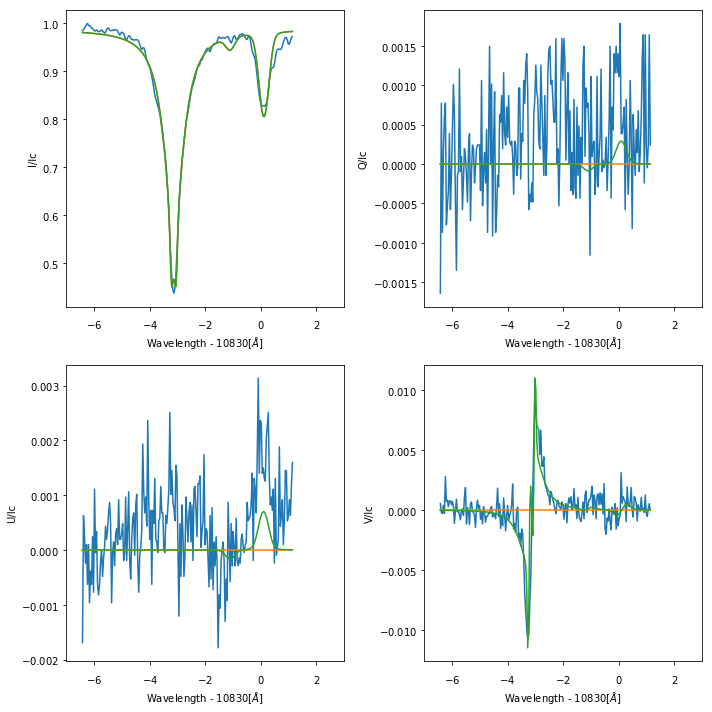

In [8]:
f = h5py.File('output.h5', 'r')

print('(npix,nrand,ncycle,nstokes,nlambda) -> {0}'.format(f['spec1']['stokes'].shape))

fig, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()
for i in range(4):
    ax[i].plot(f['spec1']['wavelength'][:] - 10830, stokes[i,:])
    for j in range(2):
        ax[i].plot(f['spec1']['wavelength'][:] - 10830, f['spec1']['stokes'][0,0,j,i,:])

for i in range(4):
    ax[i].set_xlabel('Wavelength - 10830[$\AA$]')
    ax[i].set_ylabel('{0}/Ic'.format(label[i]))
    ax[i].set_xlim([-7,3])
    
pl.tight_layout()

f.close()

Now the photospheric model:

(npix,nrand,ncycle,nz) -> (1, 1, 2, 73)


/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


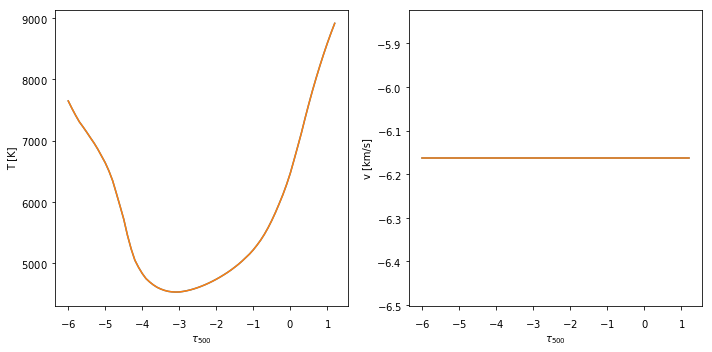

In [9]:
f = h5py.File('output.h5', 'r')

print('(npix,nrand,ncycle,nz) -> {0}'.format(f['ph1']['T'].shape))

fig, ax = pl.subplots(nrows=1, ncols=2, figsize=(10,5))
ax = ax.flatten()
for i in range(2):
    ax[0].plot(f['ph1']['log_tau'][:], f['ph1']['T'][0,0,i,:])    
    
for i in range(2):
    ax[1].plot(f['ph1']['log_tau'][:], f['ph1']['v'][0,0,i,:])

ax[0].set_xlabel(r'$\tau_{500}$')
ax[0].set_ylabel('T [K]')

ax[1].set_xlabel(r'$\tau_{500}$')
ax[1].set_ylabel('v [km/s]')
    
pl.tight_layout()

f.close()

## Spicules
Let's try to invert observations from spicules. First, we read the observations from the datafile (already on the correct reference system and with the wavelength calibration).

dict_keys(['lambda', 'heperf', 'mask_heights'])
(25, 4, 224, 101)


/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


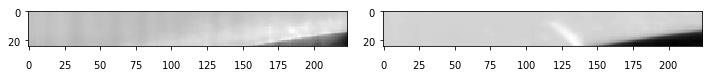

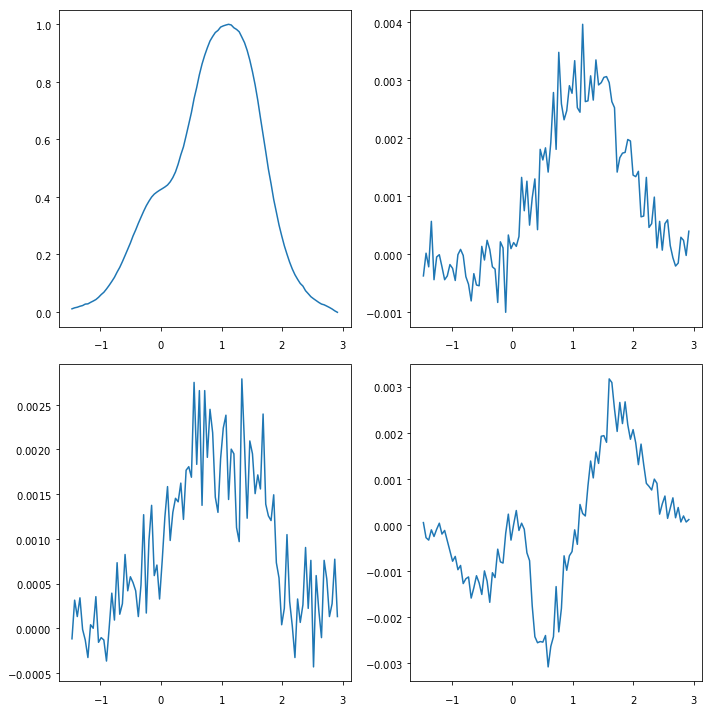

In [10]:
tmp = io.readsav('/scratch/Dropbox/test/test_hazel2/orozco/Spiculas_map.sav')
print(tmp.keys())
print(tmp['heperf'].shape)
f, ax = pl.subplots(nrows=1, ncols=2, figsize=(10,6))
ax[0].imshow(tmp['heperf'][:,0,:,0])
ax[1].imshow(tmp['heperf'][:,0,:,100])

f, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
stokes = np.zeros((4,101))
stokes[0,:] = tmp['heperf'][10,0,175,:] / np.max(tmp['heperf'][10,0,175,:])
stokes[1,:] = tmp['heperf'][10,1,175,:] / np.max(tmp['heperf'][10,0,175,:])
stokes[2,:] = tmp['heperf'][10,2,175,:] / np.max(tmp['heperf'][10,0,175,:])
stokes[3,:] = tmp['heperf'][10,3,175,:] / np.max(tmp['heperf'][10,0,175,:])
ax[0,0].plot(tmp['lambda'], stokes[0,:])
ax[0,1].plot(tmp['lambda'], stokes[1,:])
ax[1,0].plot(tmp['lambda'], stokes[2,:])
ax[1,1].plot(tmp['lambda'], stokes[3,:])

The first thing we do is estimate the noise standard deviation. You should do it more carefully so that the final values of the $\chi^2$ are close to one in case the observed profile can be correctly represented with the simple Hazel atmosphere. For the moment and as a quick estimation we just estimate it via the standard deviation in a small region close to the continuum.

In [11]:
noise=np.std(stokes[1,0:15])
print(noise)

0.00026189987900385165


Then we save several files with the observations. The first one the file with the wavelength axis. Remember that this axis is common to all observed pixels in case HDF5 files are used. We add 10829.0911 Angstrom because the osberved files are referred to this wavelength (it is the center of the multiplet).

In [12]:
np.savetxt('10830_spicules.wavelength', tmp['lambda']+10829.0911, header='lambda')

Then we save a file with the wavelength weights. For the moment, let's just weight all of them equally.

In [13]:
f = open('10830_spicules.weights', 'w')
f.write('# WeightI WeightQ WeightU WeightV\n')
for i in range(101):
    f.write('1.0    1.0   1.0   1.0\n')
f.close()
stokes.shape

(4, 101)

And finally we save the file with the observed Stokes profile, following the manual.

In [14]:
f = open('10830_spicules_stokes.1d', 'wb')
f.write(b'# LOS theta_LOS, phi_LOS, gamma_LOS\n')
f.write(b'90.0 0.0 90.0\n')
f.write(b'\n')
f.write(b'# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)\n')
f.write(b'0.0 0.0 0.0 0.0\n')
f.write(b'\n')
f.write(b'# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV\n')
tmp = np.vstack([stokes, noise*np.ones((4,101))])
np.savetxt(f, tmp.T)
f.close()

%cat 10830_spicules_stokes.1d

# LOS theta_LOS, phi_LOS, gamma_LOS
90.0 0.0 90.0

# Boundary condition I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)
0.0 0.0 0.0 0.0

# SI SQ SU SV sigmaI sigmaQ sigmaU sigmaV
1.065849605947732925e-02 -3.797253011725842953e-04 -1.178457823698408902e-04 5.237590085016563535e-05 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04
1.414149347692728043e-02 1.309397521254140884e-05 3.142554196529090405e-04 -2.749734849203377962e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04
1.621034182608127594e-02 -2.225975767942145467e-04 1.309397484874352813e-04 -3.273493784945458174e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04
1.961477473378181458e-02 5.630409577861428261e-04 3.404433664400130510e-04 -1.047518017003312707e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04 2.618998790038516472e-04
2.19978783279657

We print now the configuration file used in this case. Note that we do three cycles. The first one is used to estimate thermodynamical parameters from Stokes $I$. The second one is used to get information from the LOS component of the magnetic field using only Stokes $V$ (in this case the LOS lines along the X axis because $\theta=90\deg$ and $\chi=0\deg$). Finally, the third cycle gets information from Stokes $Q$ and $U$ to fix the other two components of the magnetic field. Some trial-and-error is necessary for setting up the weights. Also note that we fix the height to 3''. One should measure this number better in the observations and set it appropriately.

In [15]:
%cat conf_spicules.ini

# Hazel configuration File

[Working mode]
Output file = output.h5
Number of cycles = 3

# Topology
# Always photosphere and then chromosphere
# Photospheres are only allowed to be added with a filling factor
# Atmospheres share a filling factor if they are in parenthesis
# Atmospheres are one after the other with the -> operator
# Atmosphere 1 = ph2 -> ch1 -> ch2

[Spectral regions]
    [[Region 1]]
    Name = spec1
    #Wavelength = 10826, 10833, 150
    Topology = ch1
    Stokes weights = 1.0, 1.0, 1.0, 1.0
    LOS = 90.0, 0.0, 90.0
    Boundary condition = 0.0, 0.0, 0.0, 0.0       # I/Ic(mu=1), Q/Ic(mu=1), U/Ic(mu=1), V/Ic(mu=1)
    Wavelength file = '10830_spicules.wavelength'
    Wavelength weight file = '10830_spicules.weights'
    Observations file = '10830_spicules_stokes.1d'    
    Weights Stokes I = 1.0, 0.1, 0.1, 0.0
    Weights Stokes Q = 0.0, 0.0, 1.0, 0.0
    Weights Stokes U = 0.0, 0.0, 1.0, 0.0
    Weights Stokes V = 0.0, 1.0, 1.0, 0.0
    Mask file = None

[Atmospher

Finally, let's carry out the inversion. We activate some verbosity to analyze the inversion.

In [16]:
mod = hazel.Model('conf_spicules.ini', working_mode='inversion', verbose=2)
mod.read_observation()
mod.open_output()
mod.invert()
mod.write_output()
mod.close_output()

2018-09-13 12:28:49,579 - Adding spectral region spec1
2018-09-13 12:28:49,580 -   - Reading wavelength axis from 10830_spicules.wavelength
2018-09-13 12:28:49,583 -   - Reading wavelength weights from 10830_spicules.weights
2018-09-13 12:28:49,586 -   - Using observations from 10830_spicules_stokes.1d
2018-09-13 12:28:49,587 -   - No mask for pixels
2018-09-13 12:28:49,588 -   - No instrumental profile
2018-09-13 12:28:49,589 -   - Using LOS ['90.0', '0.0', '90.0']
2018-09-13 12:28:49,591 -   - Using off-limb normalization (peak intensity)
2018-09-13 12:28:49,592 -   - Using boundary condition ['0.0', '0.0', '0.0', '0.0']
2018-09-13 12:28:49,594 - Using 3 cycles
2018-09-13 12:28:49,594 - Not using randomizations
2018-09-13 12:28:49,595 - Adding atmospheres
2018-09-13 12:28:49,596 -   - New available chromosphere : ch1
2018-09-13 12:28:49,597 -     * Adding line : 10830
2018-09-13 12:28:49,598 -     * Magnetic field reference frame : vertical
2018-09-13 12:28:49,599 -     * Reading 1D 

After some seconds, we end up with the following fit for all cycles:

(npix,nrand,ncycle,nstokes,nlambda) -> (1, 1, 3, 4, 101)


/scratch/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


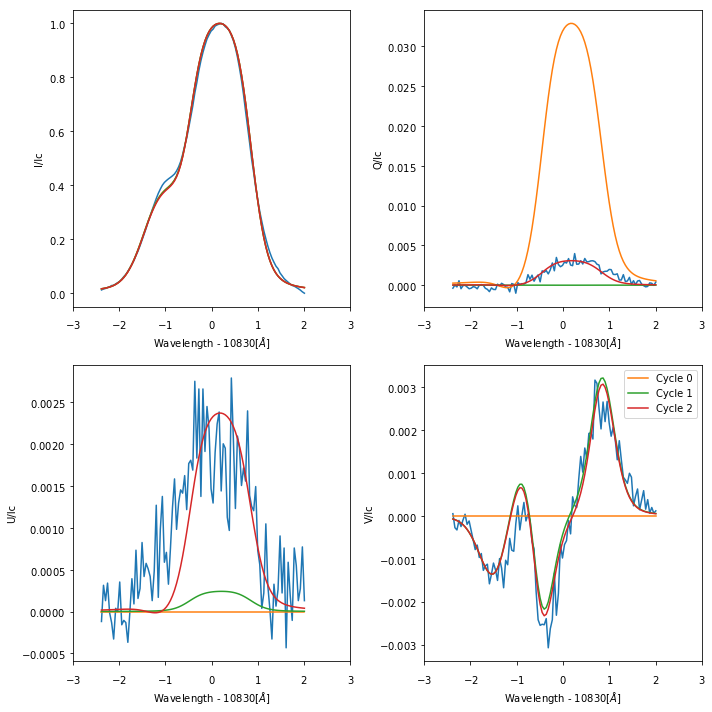

In [17]:
f = h5py.File('output.h5', 'r')

print('(npix,nrand,ncycle,nstokes,nlambda) -> {0}'.format(f['spec1']['stokes'].shape))

ncycle = f['spec1']['stokes'].shape[2]

fig, ax = pl.subplots(nrows=2, ncols=2, figsize=(10,10))
ax = ax.flatten()
for i in range(4):
    ax[i].plot(f['spec1']['wavelength'][:] - 10830, stokes[i,:])
    for j in range(ncycle):
        ax[i].plot(f['spec1']['wavelength'][:] - 10830, f['spec1']['stokes'][0,0,j,i,:], label='Cycle {0}'.format(j))

for i in range(4):
    ax[i].set_xlabel('Wavelength - 10830[$\AA$]')
    ax[i].set_ylabel('{0}/Ic'.format(label[i]))
    ax[i].set_xlim([-3,3])
    
pl.legend()
pl.tight_layout()

f.close()